# Comparing the Classification Performance of Various Models on Coronavirus Tweets

[Kaggle dataset](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification?resource=download)

This is a dataset of COVID-era tweets and their hand-labeled sentiments. In this problem, we will use the TF-IDF values of unigrams and bigrams and determine the probable sentiment of the tweet as either positive, negative, neutral, or extremely positive / negative.

The dataset is pre-split into training and test data, which serves to be convenient for our purposes, as we can fit a TF-IDF vectorizer on just the training split to ensure there's no data leakage in the form of vocabulary (something I realized could be a pretty big factor in evaluating the "true" generalization power of each model for this task).

## Part 1: Load in data

In [3]:
import pandas as pd
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aditya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_df = pd.read_csv('Corona_NLP_train.csv', encoding = "ISO-8859-1", dtype = {'Sentiment': 'category'})
test_df = pd.read_csv('Corona_NLP_test.csv', encoding = "ISO-8859-1", dtype = {'Sentiment': 'category'})

In [5]:
train_df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
train_tweets = train_df[['OriginalTweet', 'Sentiment']]
test_tweets = test_df[['OriginalTweet', 'Sentiment']]

## Part 2: Explore the Data

Let's look at the distributions of the tweet sentiments.

<Axes: title={'center': 'Training Sentiment Distribution'}>

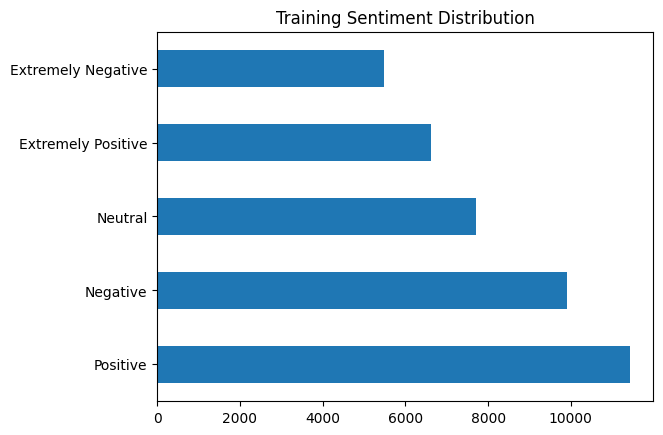

In [7]:
train_tweets['Sentiment'].value_counts().plot(kind='barh', title='Training Sentiment Distribution')

<Axes: title={'center': 'Test Sentiment Distribution'}>

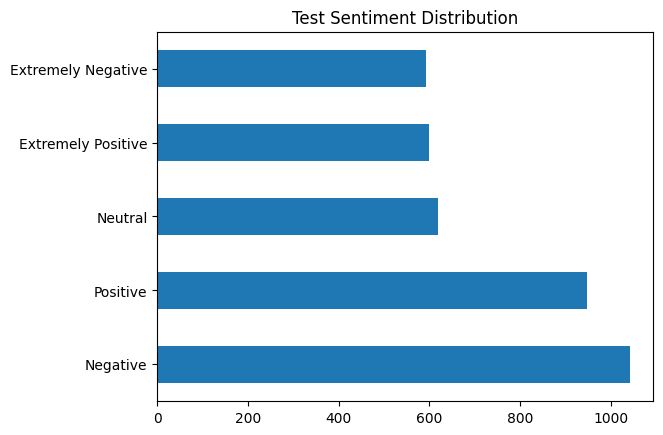

In [8]:
test_tweets['Sentiment'].value_counts().plot(kind='barh', title='Test Sentiment Distribution')

We can see that we have quite a few positive and negative tweets, and fewer that are in the middle or in the extremes. In general, this distribution is pretty even for the training and the test data.

## Part 3: Vectorize train & test tweets

Vectorize tweets, removing stop words and limiting the document frequency of unigrams/bigrams to 5%. 

> **Note**
> 
> Because of the high dimensionality of each TF-IDF vector due to the high vocabulary exhibited in the dataset and the number of documents in the training set combined with the computing session and RAM limits of environments such as Google Colab and my local computer, I had to choose this arbitrary limit and focus only on unigrams (because extending the n-gram range would further increase the dimensionality of the TF-IDF vector).
>
> Unfortunately, this severely limited the performance of every model I tested, as I will acknowledge in the conclusion.

In [9]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords = list(set(stopwords.words('english')))
vectorizer = TfidfVectorizer(max_df=0.05, stop_words=stopwords)

In [10]:
train_tweets_vectorized = vectorizer.fit_transform(train_tweets['OriginalTweet']).toarray()

In [11]:
test_tweets_vectorized = vectorizer.transform(test_tweets['OriginalTweet']).toarray()

In [12]:
len(vectorizer.vocabulary_)

80253

## Part 4: Convert sentiments to numerical values

In [13]:
train_sentiments = train_tweets['Sentiment'].cat.codes.to_numpy()
test_sentiments = test_tweets['Sentiment'].cat.codes.to_numpy()

In [14]:
sentiments = train_tweets['Sentiment'].cat.categories.to_list()

## Part 5: Train Naive Bayes classifier and perform predictions

In [19]:
from sklearn.naive_bayes import MultinomialNB

# utility function to load model
def load_model(model_path: str):
    import pickle
    with open(model_path, 'rb') as f:
        return pickle.load(f)

def save_model(model, model_path: str):
    import pickle
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

# whether to train the model from scratch or load from disk
train_nb = False
naive_bayes: MultinomialNB = MultinomialNB()

if train_nb:
    naive_bayes.fit(train_tweets_vectorized, train_sentiments)
    save_model(naive_bayes, './models/naive_bayes_model.pkl')
else:
    naive_bayes = load_model('./models/naive_bayes_model.pkl')

In [20]:
naive_bayes_pred = naive_bayes.predict(test_tweets_vectorized)

## Part 6: Train Logistic Regression model and perform predictions

In [21]:
from sklearn.linear_model import LogisticRegression

# whether to train the model from scratch or load from disk
train_logreg = False
logreg: LogisticRegression = LogisticRegression(solver='saga', n_jobs=-1)

if train_logreg:
    logreg.fit(train_tweets_vectorized, train_sentiments)
    save_model(logreg, './models/logreg_model.pkl')
else:
    logreg = load_model('./models/logreg_model.pkl')

In [22]:
logreg_pred = logreg.predict(test_tweets_vectorized)

## Part 7: Train Neural Network model and perform predictions

In [23]:
from sklearn.neural_network import MLPClassifier

# whether to train the model from scratch or load from disk
train_nn = False
nn: MLPClassifier = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(15, 20), random_state=1)

if train_nn:
    nn.fit(train_tweets_vectorized, train_sentiments)
    save_model(nn, './models/nn_model.pkl')
else:
    nn = load_model('./models/nn_model.pkl')

In [24]:
nn.score(train_tweets_vectorized, train_sentiments)

0.9999028111864324

In [25]:
nn_pred = nn.predict(test_tweets_vectorized)

## Part 8: Compare results

In [26]:
from sklearn.metrics import classification_report

In [27]:
for idx, sentiment in enumerate(sentiments):
    print(f"{idx} - {sentiment}")

0 - Extremely Negative
1 - Extremely Positive
2 - Negative
3 - Neutral
4 - Positive


In [28]:
print('Naive Bayes')
print(classification_report(test_sentiments, naive_bayes_pred))

Naive Bayes
              precision    recall  f1-score   support

           0       0.75      0.01      0.02       592
           1       0.95      0.03      0.06       599
           2       0.39      0.38      0.38      1041
           3       0.80      0.03      0.06       619
           4       0.31      0.90      0.47       947

    accuracy                           0.34      3798
   macro avg       0.64      0.27      0.20      3798
weighted avg       0.58      0.34      0.25      3798



In [29]:
print('Logistic Regression')
print(classification_report(test_sentiments, logreg_pred))

Logistic Regression
              precision    recall  f1-score   support

           0       0.61      0.42      0.49       592
           1       0.66      0.53      0.59       599
           2       0.47      0.51      0.49      1041
           3       0.61      0.54      0.58       619
           4       0.46      0.61      0.53       947

    accuracy                           0.53      3798
   macro avg       0.56      0.52      0.54      3798
weighted avg       0.54      0.53      0.53      3798



In [30]:
print('Neural Networks')
print(classification_report(test_sentiments, nn_pred))

Neural Networks
              precision    recall  f1-score   support

           0       0.56      0.53      0.54       592
           1       0.63      0.61      0.62       599
           2       0.45      0.44      0.44      1041
           3       0.51      0.47      0.49       619
           4       0.45      0.50      0.47       947

    accuracy                           0.50      3798
   macro avg       0.52      0.51      0.51      3798
weighted avg       0.50      0.50      0.50      3798



## Part 9: Summary of results

Each of these approaches produced varying results, all of which are explainable considering the nature of the data. I also briefly discuss some constraints I faced and future improvements.

All metrics below are discussed in terms of the pre-split test set.

### Naïve Bayes
The Naïve Bayes approach performed the worst, both in terms of accuracy and the balance of precision and recall (as measured by $F_1$ score). With a paltry 34% accuracy and a weighted $F_1$ score of 0.25, this approach perfomed poorly to the unigram TF-IDF vector to sentiment mapping task presented in this experiment. This makes sense, because the driving assumption of Naïve Bayes is that each predictor (feature) is independent of one another, which is clearly not the case in language (which is a order and sequence-dependent task).

What I found particularly interesting here was the low to mid-range $F_1$ scores for the two most-present classes (`Negative` and `Positive`) in comparison to the basically nascent performance on all the other classes. This seems to suggest that perhaps this approach could scale well to more training samples.

### Neural Networks
Surprisingly, the neural network-based approach came in second, with a middling accuracy of 50% and a weighted $F_1$ score of 0.5 as well. I suspect the poor performance is due to the scaling back of the TF-IDF vector size, which is disappointing.

Based on the training accuracy, it unfortunately seems like the model has overfit on the data. As such, it may be useful to explore early-stopping heuristics.

### Logistic Regression
This approach performed the best, with a 53% accuracy rate and a weighted $F_1$ score of 0.53. This sort of makes sense, because I can imagine a linear combination of TF-IDF scores corresponding to each term could be weighted to produce classifications.

## Part 10: Improving performance
There are various approaches that I didn't get to try due to the RAM limits I was hitting both on Colab and my local machine. In no particular order, here are my thoughts:

### Increasing n-gram length
I believe that due to the nature of text data, providing more context in the form of TF-IDF for more than unigrams would be beneficial to determine sentiment of texts. Even adding bigrams and trigrams would be massively beneficial to performance, at the cost of higher sparsity in each vector.

### Decreasing sparsity using dimensionality reduction techniques
One technique I've found very useful to reduce sparsity of vectors in text datasets (in particular, for my chatbot project) is to utilize dimensionality reduction algorithms to project vectors down into a lower-dimensional space, creating low-rank sparse vectors that reduce the number of parameters in each model with little to no cost on perfomance. This may solve the RAM issue once the dimensionality reduction runs in most cases, but unfortunately, I was still hitting this issue just running the SVD algorithm in the Colab VM. If I had more time to work on this assignment, I'd be able to first convert documents into these low-rank dense representations and then move forward from there.

### Pre-trained document vectorizers
I interpreted the directions of the assignment to not allow the use of this technique, but this would vastly improve performance without needing the previous two techniques. Using models trained on large corpuses would allow us to use dense low-rank document vectors that also have some contextual understanding. This would also allow us to get away with using a really small number of parameters on the sentiment model too, at the cost of higher upfront compute cost.
